In [30]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
import subprocess
import shutil
from PIL import Image

/home/ssaral/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


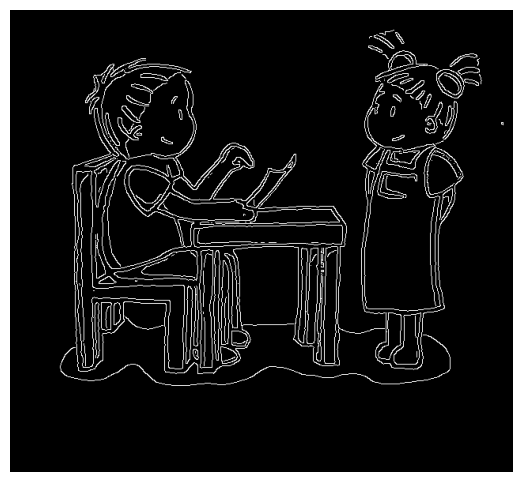

In [1]:
# Load the original image
image = cv2.imread('comic_orig_2.png', cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray, threshold1=10, threshold2=15)

# Display and save the result
plt.figure(figsize=(12, 6))
plt.imshow(edges, cmap='gray')
plt.axis('off')
# plt.savefig("comic_orig_2_edgemap_th1_th2.png", bbox_inches='tight')
plt.show()


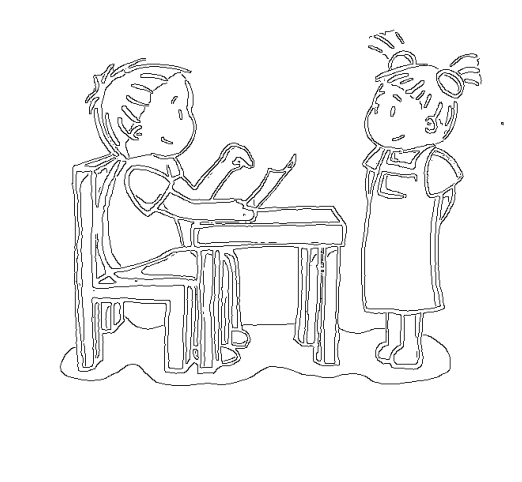

In [3]:
# Invert the edge map
inverted_edge_map = np.where(edges == 0, 255, 0).astype(np.uint8)

plt.figure(figsize=(12, 6))
plt.imshow(inverted_edge_map, cmap='gray')
# plt.savefig("comic_orig_2_inverted_edgemap.png", bbox_inches='tight')
plt.axis('off')
plt.show()

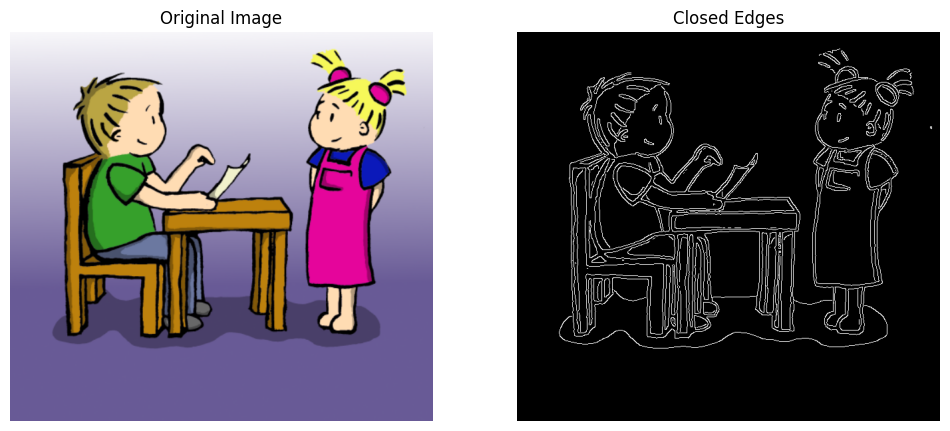

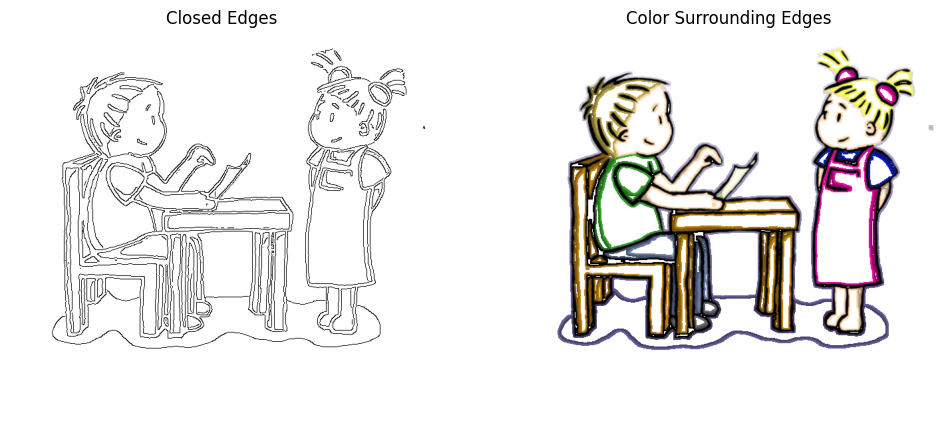

In [28]:

def colorize_edges_manually(image, edge_map, kernel_size=5):
    # Initialize a blank canvas for the colored edges
    colorized_edges = np.zeros_like(image)
    colorized_edges += 255

    # Get half the kernel size
    k = kernel_size // 2

    # Iterate through the edge map
    for i in range(k, edge_map.shape[0] - k):
        for j in range(k, edge_map.shape[1] - k):
            # If it's an edge pixel
            if edge_map[i, j] != 0:
                # Extract the kernel region from the original image
                patch = image[i-k:i+k+1, j-k:j+k+1]
                # Fill the kernel region in the colorized edge map
                colorized_edges[i-k:i+k+1, j-k:j+k+1] = patch

    return colorized_edges

# Get the color edges and closed edges
colorized_edges = colorize_edges_manually(image, edges)

# Plot Results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Closed Edges")
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Closed Edges")
plt.imshow(inverted_edge_map, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Color Surrounding Edges")
plt.imshow(cv2.cvtColor(colorized_edges, cv2.COLOR_BGR2RGB))
# plt.savefig("comic_orig_2_coloredge_k20.png", bbox_inches='tight')
plt.axis('off')

# plt.savefig("comic_orig_2_edgesmap_coloredge.png", dpi=300, bbox_inches='tight')

plt.show()




In [29]:
pbmtojbg_path = "/home/ssaral/Downloads/jbigkit-2.1/pbmtools/pbmtojbg"
jbgtopbm_path = "/home/ssaral/Downloads/jbigkit-2.1/pbmtools/jbgtopbm"

zpaq v7.15 journaling archiver, compiled Jan  5 2021
compressed_color_map.zpaq: 5 versions, 5 files, 9 fragments, 0.163371 MB
Updating compressed_color_map.zpaq at offset 163371 + 0
Adding 1.116180 MB in 1 files -method 14 -threads 8 at 2024-11-24 16:02:57.
100.00% 0:00:00 # color_map.bin 1116180 -> 0
1 +added, 0 -removed.
Compression completed. Files saved.
zpaq v7.15 journaling archiver, compiled Jan  5 2021
compressed_color_map.zpaq: 6 versions, 6 files, 9 fragments, 0.163952 MB
Extracting 1.116180 MB in 1 files -threads 8
[1..9] -> 1116224
> temp_decompress_dir/color_map.bin
Decompression completed.



0.163371 + (1.116180 -> 0.000000 -> 0.000581) = 0.163952 MB
0.012 seconds (all OK)
0.022 seconds (all OK)


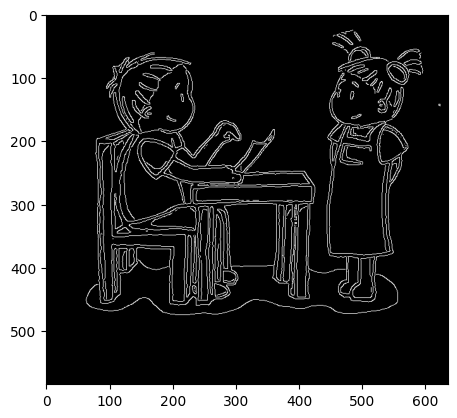

In [19]:
# === JBIG Compression for Edge Map === #

# Save edge map as PBM
def save_bilevel_image(edge_image, output_path):
    binary_image = (edge_image > 0).astype(np.uint8)
    binary_image *= 255  # Scale to 255 for PBM format
    image = Image.fromarray(binary_image)
    image.save(output_path)

# Compress edge map using JBIG
def compress_edge_map_with_jbig(edge_map, jbig_output_path):
    pbm_path = "edge_map.pbm"
    save_bilevel_image(edge_map, pbm_path)
    subprocess.run([pbmtojbg_path, pbm_path, jbig_output_path], check=True)
    os.remove(pbm_path)  # Cleanup temporary PBM file

# Decompress edge map using JBIG
def decompress_edge_map_with_jbig(jbig_input_path, shape):
    pbm_path = "decoded_edge_map.pbm"
    subprocess.run([jbgtopbm_path, jbig_input_path, pbm_path], check=True)
    decoded_edge_map = cv2.imread(pbm_path, cv2.IMREAD_GRAYSCALE)
    os.remove(pbm_path)  # Cleanup temporary PBM file
    return decoded_edge_map

# === ZPAQ Compression for Color Map === #

# Compress color map using ZPAQ
def compress_color_map_with_zpaq(color_map, zpaq_output_path):
    input_file = "color_map.bin"
    color_map.tofile(input_file)  # Save color map to binary file
    try:
        subprocess.run(f"zpaq add {zpaq_output_path} {input_file}", shell=True, check=True)
    finally:
        os.remove(input_file)  # Cleanup temporary binary file



def decompress_color_map_with_zpaq(zpaq_input_path, shape):
    # Create a temporary directory for extraction
    temp_dir = "temp_decompress_dir"
    os.makedirs(temp_dir, exist_ok=True)

    # Use the directory as the target for extraction
    subprocess.run(f"zpaq extract {zpaq_input_path} -to {temp_dir}", shell=True, check=True)

    # Locate the decompressed file (assume single .bin file in the archive)
    extracted_file_path = os.path.join(temp_dir, "color_map.bin")
    if not os.path.exists(extracted_file_path):
        raise FileNotFoundError(f"Expected file 'color_map.bin' not found in {temp_dir}")

    # Load the decompressed file into a NumPy array
    decoded_color_map = np.fromfile(extracted_file_path, dtype=np.uint8).reshape(shape)

    # Clean up the temporary directory
    shutil.rmtree(temp_dir)

    return decoded_color_map


# === Main Workflow === #
def compress_and_save(edge_map, color_map, edge_map_output_path, color_map_output_path):
    # Compress and save edge map
    compress_edge_map_with_jbig(edge_map, edge_map_output_path)

    # Compress and save color map
    compress_color_map_with_zpaq(color_map, color_map_output_path)

def load_and_decompress(edge_map_input_path, color_map_input_path, edge_map_shape, color_map_shape):
    # Decompress edge map
    decoded_edge_map = decompress_edge_map_with_jbig(edge_map_input_path, edge_map_shape)

    # Decompress color map
    decoded_color_map = decompress_color_map_with_zpaq(color_map_input_path, color_map_shape)

    return decoded_edge_map, decoded_color_map


if __name__ == "__main__":
    edge_map = edges  # Loading  edge map
    color_map = colorized_edges # Loading color map

    # Paths for compressed files
    edge_map_output_path = "compressed_edge_map.jbig"
    color_map_output_path = "compressed_color_map.zpaq"

    # Compress and save
    compress_and_save(edge_map, color_map, edge_map_output_path, color_map_output_path)
    print("Compression completed. Files saved.")

    # Simulate reloading and decompression
    decoded_edge_map, decoded_color_map = load_and_decompress(
        edge_map_output_path,
        color_map_output_path,
        edge_map.shape,
        color_map.shape
    )
    print("Decompression completed.")

    # Save decompressed results for verification
    # cv2.imwrite("decoded_edge_map.png", decoded_edge_map)
    # cv2.imwrite("decoded_color_map.png", decoded_color_map)


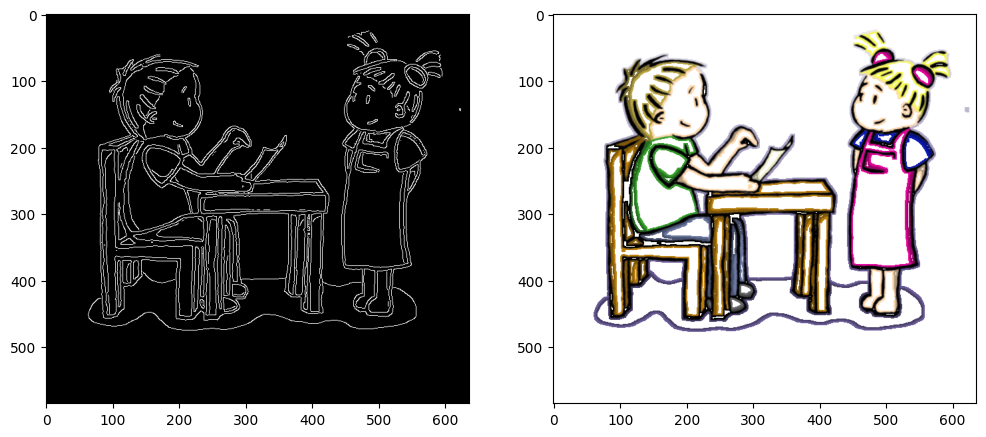

In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(decoded_edge_map, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(decoded_color_map, cv2.COLOR_BGR2RGB))

(-0.5, 635.5, 584.5, -0.5)

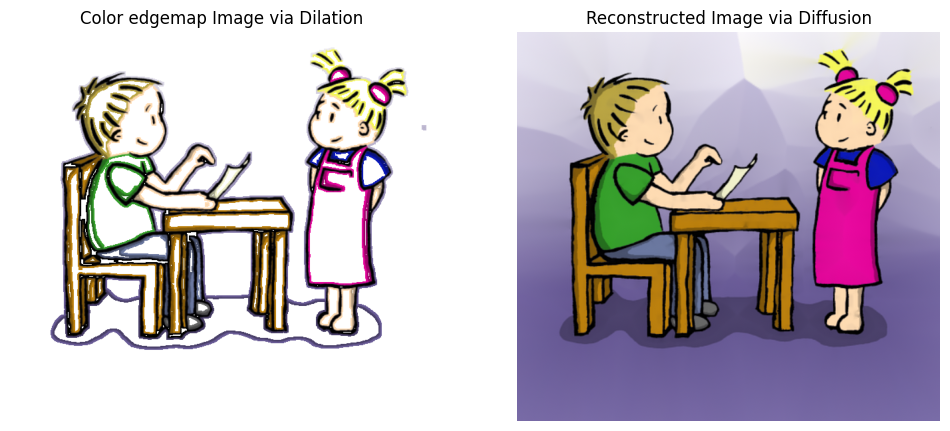

In [36]:
kernel = np.ones((5, 5), np.uint8)  # Adjust kernel size as needed
dilated_edges = cv2.dilate(decoded_edge_map, kernel, iterations=1)

reconstructed_image = cv2.inpaint(decoded_color_map, 255 - dilated_edges, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(decoded_color_map, cv2.COLOR_BGR2RGB))
# plt.savefig("comic_orig_2_coloredge_dilation_k5_r10.png", bbox_inches='tight')
plt.title('Color edgemap Image via Dilation')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))
# plt.savefig("comic_orig_2_reconstructed_k5_r10.png", bbox_inches='tight')
plt.title('Reconstructed Image via Diffusion')
plt.axis('off')